In [33]:
# %%
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
DATA_DIR = os.path.join("..", "data", "raw")
IMG_DIR = os.path.join("..", "reports", "figures")
os.makedirs(IMG_DIR, exist_ok=True)

# Target States FIPS for filtering
TARGET_FIPS = ["24", "11", "51"]  # MD, DC, VA

In [34]:
# %%
# --- OPTIONAL: DOWNLOAD & UNZIP DATA ---
# Set this to True ONLY if you need to download/unzip the data again.
# Otherwise, keep it False to save time and bandwidth.
DOWNLOAD_DATA = False

if DOWNLOAD_DATA:
    import sys
    import os
    
    # Add the 'src' directory to the path so we can import our scripts
    # (Assuming notebooks/ is one level down from root)
    sys.path.append(os.path.abspath(os.path.join('..', 'src')))
    
    print("🚀 Starting Data Download Pipeline...")
    
    try:
        # 1. Download ACS PUMS (Person & Housing) - Massive files!
        import download_acs
        print("\n--- 1. Downloading ACS PUMS (MD, DC, VA) ---")
        download_acs.download_acs_data()
        
        # 2. Download ACS Tract Data (The "Canvas")
        import download_tract_data
        print("\n--- 2. Downloading ACS Tract Data (Buckets & Outcomes) ---")
        download_tract_data.main()
        
        # 3. Download SAIPE (County Validation)
        # (Only if you created this script, otherwise skip)
        try:
            import download_saipe
            print("\n--- 3. Downloading SAIPE (County Poverty Estimates) ---")
            download_saipe.main()
        except ImportError:
            print("\n⚠️ Skipping SAIPE: 'src/download_saipe.py' not found.")
            
        print("\n✅ All downloads complete!")
        
    except Exception as e:
        print(f"\n❌ Error during download: {e}")
        print("Check if your 'src' folder contains the download scripts.")
else:
    print("✅ Skipping download. Using existing data in '../data/raw'.")

✅ Skipping download. Using existing data in '../data/raw'.


In [35]:
# %%
# --- OPTIONAL: DOWNLOAD & PROCESS DATA ---
# Set this to True to fetch fresh data or re-process the raw files.
DOWNLOAD_DATA = True 

if DOWNLOAD_DATA:
    import sys
    import os
    
    # Add 'src' to path so we can import our scripts
    sys.path.append(os.path.abspath(os.path.join('..', 'src')))
    
    print("🚀 Starting Data Pipeline...")
    
    try:
        # 1. Download ACS PUMS (MD, DC, VA)
        import download_acs
        print("\n--- 1. Downloading ACS PUMS ---")
        download_acs.download_acs_data()
        
        # 2. Download ACS Tract Data (Buckets)
        import download_tract_data
        print("\n--- 2. Downloading ACS Tract Data ---")
        download_tract_data.main()
        
        # 3. Process SNAP Data (Unzip & Clean)
        # This uses your new unzip_snap.py script
        import unzip_snap
        print("\n--- 3. Processing SNAP Data ---")
        unzip_snap.process_snap_data()
        
        # 4. Download SAIPE (If you have it)
        try:
            import download_saipe
            print("\n--- 4. Downloading SAIPE ---")
            download_saipe.main()
        except ImportError:
            print("\n(Skipping SAIPE download - script not found)")
            
        print("\n✅ Pipeline Complete! All data is in '../data/raw'")
        
    except Exception as e:
        print(f"\n❌ Error in pipeline: {e}")
else:
    print("✅ Skipping download/processing. Using existing data.")

🚀 Starting Data Pipeline...

--- 1. Downloading ACS PUMS ---
Saving data to: /Users/zhenyuyue/Erdos/project/src/../data/raw

Target Region: ['MD', 'DC', 'VA']
Fetching file list from Census Bureau...
Found 12 files to download.
[1/12] Downloading csv_hdc.zip... Done.
[2/12] Downloading csv_hmd.zip... Done.
[3/12] Downloading csv_hva.zip... Done.
[4/12] Downloading csv_pdc.zip... Done.
[5/12] Downloading csv_pmd.zip... Done.
[6/12] Downloading csv_pva.zip... Done.
[7/12] Downloading sas_hdc.zip... Done.
[8/12] Downloading sas_hmd.zip... Done.
[9/12] Downloading sas_hva.zip... Done.
[10/12] Downloading sas_pdc.zip... Done.
[11/12] Downloading sas_pmd.zip... Done.
[12/12] Downloading sas_pva.zip... Done.

Success! All files extracted to: /Users/zhenyuyue/Erdos/project/src/../data/raw

--- 2. Downloading ACS Tract Data ---
--- Downloading Tract Buckets (Sex x Age) + Outcomes ---
  Fetching data for MD (FIPS 24)...
  Fetching data for DC (FIPS 11)...
  Fetching data for VA (FIPS 51)...

✅ S

In [36]:
# %%
# --- FIX: CLEAN SNAP IDS ---
# The FIPS column currently has text like "1100161 DC FSP...".
# We will extract the first 5 digits and save it as the official key.

if 'fips' in df_snap_dmv.columns:
    # 1. Force to string
    # 2. Strip whitespace (just in case)
    # 3. Take the first 5 characters
    df_snap_dmv['GEOID_COUNTY'] = df_snap_dmv['fips'].astype(str).str.strip().str[:5]
    
    print("✅ SNAP IDs Cleaned.")
    print(f"Sample: {df_snap_dmv['GEOID_COUNTY'].head(3).tolist()}")
    
    # Verify they look like '11001', '24031' (5 digits)
    lengths = df_snap_dmv['GEOID_COUNTY'].str.len().unique()
    print(f"ID Lengths present: {lengths} (Should be only [5])")
else:
    print("❌ Column 'fips' not found in df_snap_dmv")

✅ SNAP IDs Cleaned.
Sample: ['11001', '24001', '24003']
ID Lengths present: [5] (Should be only [5])


In [37]:
# %%
# --- LOAD, CLEAN, AND INSPECT ---
# This block performs 3 steps:
# 1. Load the raw data.
# 2. FILTER out "Group Quarters" (Dorms/Prisons) which cause the NaNs.
# 3. Rename columns to English and display a clean sample.

def load_and_clean_pums(rows_to_show=10):
    print("Loading and Cleaning PUMS Data...")
    
    # 1. FIND FILES
    p_files = glob.glob(os.path.join(DATA_DIR, "psam_p*.csv"))
    h_files = glob.glob(os.path.join(DATA_DIR, "psam_h*.csv"))
    
    if not p_files or not h_files:
        print("❌ Missing PUMS files. Run the download block.")
        return None, None

    # 2. LOAD (We load 5000 rows for the preview to ensure we get enough valid households)
    # In production, you will remove 'nrows=5000' to load everything.
    df_p = pd.read_csv(p_files[0], nrows=5000)
    df_h = pd.read_csv(h_files[0], nrows=5000)
    
    # 3. FILTER (The Critical Fix for NaNs)
    # We drop rows where Poverty Status (POVPIP) is NaN.
    # This automatically removes Group Quarters (GQ) and keeps only Housing Units.
    df_p_clean = df_p.dropna(subset=['POVPIP']).copy()
    
    # 4. RENAME to English
    p_rename = {
        'SERIALNO': 'Household_ID',
        'AGEP': 'Age',
        'SEX': 'Sex_Code',      # 1=Male, 2=Female
        'RAC1P': 'Race_Code',   # 1=White, 2=Black, etc.
        'SCHL': 'Education_Lvl',
        'POVPIP': 'Poverty_Ratio', # <100 is Poor
        'WAGP': 'Wages_Yearly',
        'WKHP': 'Hours_Worked_Weekly'
    }
    df_p_clean.rename(columns=p_rename, inplace=True)
    
    print(f"✅ Data Loaded. Kept {len(df_p_clean)} valid Person records (dropped {len(df_p) - len(df_p_clean)} GQ rows).")
    print("Poverty Ratio is income divided by poverty threshold.")
    
    # 5. DISPLAY
    print(f"\n{'='*20} PREVIEW: PERSON DATA (INDIVIDUALS) {'='*20}")
    cols = ['Household_ID', 'Age', 'Sex_Code', 'Race_Code', 'Education_Lvl', 'Wages_Yearly', 'Poverty_Ratio']
    display(df_p_clean[cols].head(rows_to_show))
    
    return df_p_clean, df_h

# Run it
df_p_clean, df_h = load_and_clean_pums(rows_to_show=10)

Loading and Cleaning PUMS Data...
✅ Data Loaded. Kept 4491 valid Person records (dropped 509 GQ rows).
Poverty Ratio is income divided by poverty threshold.

==================== PREVIEW: PERSON DATA (INDIVIDUALS) ====================


,Household_ID,Age,Sex_Code,Race_Code,Education_Lvl,Wages_Yearly,Poverty_Ratio
0,2023GQ0000515,75,1,2,18.0,0.0,0.0
8,2023GQ0002296,55,1,2,18.0,0.0,58.0
15,2023GQ0005639,50,1,1,24.0,30000.0,204.0
28,2023GQ0009076,53,1,1,24.0,43000.0,290.0
42,2023GQ0014288,56,1,2,16.0,0.0,64.0
44,2023GQ0014652,27,1,1,22.0,0.0,0.0
46,2023GQ0014880,51,1,2,20.0,0.0,114.0
54,2023GQ0017494,59,1,2,1.0,0.0,0.0
64,2023GQ0020507,61,1,1,24.0,110000.0,501.0
65,2023GQ0020634,44,1,1,24.0,60000.0,390.0


In [38]:
# %%
# --- INSPECT: HOUSING, TRACTS, AND SNAP ---

def inspect_remaining_datasets(rows_to_show=10):
    
    # =========================================================
    # 2. HOUSING DATA (The "Context")
    # =========================================================
    print(f"\n{'='*20} PREVIEW: HOUSING DATA (HOUSEHOLDS) {'='*20}")
    
    # Load if not already loaded (Safety check)
    h_files = glob.glob(os.path.join(DATA_DIR, "psam_h*.csv"))
    if h_files:
        df_h = pd.read_csv(h_files[0], nrows=5000)
        
        # CLEAN: Drop rows with no Household Income (Vacant units or GQ)
        df_h_clean = df_h.dropna(subset=['HINCP']).copy()
        
        # RENAME
        h_rename = {
            'SERIALNO': 'Household_ID',
            'HINCP': 'Household_Income',
            'GRNTP': 'Rent_Monthly',      # Gross Rent (includes utilities)
            'NP': 'Family_Size',          # Number of People
            'VALP': 'Property_Value',     # For homeowners
            'TEN': 'Home_Own_Status'      # 1=Owned, 3=Rented
        }
        df_h_clean.rename(columns=h_rename, inplace=True)
        
        # SELECT & DISPLAY
        h_cols = ['Household_ID', 'Household_Income', 'Rent_Monthly', 'Family_Size', 'Property_Value', 'Home_Own_Status']
        # Use errors='ignore' in case a column like Property_Value is all NaN and dropped in some extracts
        display(df_h_clean[h_cols].head(rows_to_show))
        print(f"✅ Housing Data: Kept {len(df_h_clean)} occupied units.")

    # =========================================================
    # 3. TRACT DATA (The "Target Canvas")
    # =========================================================
    print(f"\n{'='*20} PREVIEW: CENSUS TRACTS (TARGETS) {'='*20}")
    
    tract_path = os.path.join(DATA_DIR, "acs_tract_demographics_2023.csv")
    if os.path.exists(tract_path):
        df_tract = pd.read_csv(tract_path)
        
        # We have ~50 columns (buckets). Let's just show the Key Indicators.
        t_cols = ['GEOID', 'census_name', 'total_population', 'median_household_income', 'poverty_count']
        
        # Clean up the GEOID for display (ensure it's a string)
        if 'GEOID' in df_tract.columns:
            df_tract['GEOID'] = df_tract['GEOID'].astype(str)
            
        display(df_tract[t_cols].head(rows_to_show))
    else:
        print("❌ Tract data not found.")

    # =========================================================
    # 4. SNAP DATA (The "Validation")
    # =========================================================
    print(f"\n{'='*20} PREVIEW: USDA SNAP DATA (GROUND TRUTH) {'='*20}")
    
    snap_path = os.path.join(DATA_DIR, "snap_county_data_clean.csv")
    if os.path.exists(snap_path):
        df_snap = pd.read_csv(snap_path)
        
        # Fix FIPS again just for display (ensure 5 digits)
        if 'fips' in df_snap.columns:
             df_snap['fips'] = df_snap['fips'].astype(str).str.zfill(5).str[:5]
             
        display(df_snap.head(rows_to_show))
    else:
        print("❌ SNAP data not found.")

# Run it
inspect_remaining_datasets()


==================== PREVIEW: HOUSING DATA (HOUSEHOLDS) ====================


,Household_ID,Household_Income,Rent_Monthly,Family_Size,Property_Value,Home_Own_Status
607,2023HU0000257,171000.0,2922.0,3,NaN,3.0
608,2023HU0000277,160000.0,2590.0,2,NaN,3.0
609,2023HU0000364,100000.0,1750.0,1,NaN,3.0
610,2023HU0000434,98000.0,NaN,2,750000.0,1.0
611,2023HU0000890,144200.0,NaN,1,241000.0,1.0
612,2023HU0001673,77600.0,2870.0,2,NaN,3.0
613,2023HU0001790,10900.0,250.0,1,NaN,3.0
614,2023HU0001949,140100.0,3880.0,2,NaN,3.0
615,2023HU0002586,240500.0,NaN,2,450000.0,1.0
616,2023HU0002965,58000.0,1800.0,2,NaN,3.0


✅ Housing Data: Kept 3157 occupied units.

==================== PREVIEW: CENSUS TRACTS (TARGETS) ====================


,GEOID,census_name,total_population,median_household_income,poverty_count
0,24001000100,Census Tract 1; Allegany County; Maryland,3153,62636,297
1,24001000200,Census Tract 2; Allegany County; Maryland,4094,64583,364
2,24001000500,Census Tract 5; Allegany County; Maryland,2269,44911,528
3,24001000600,Census Tract 6; Allegany County; Maryland,2829,55234,366
4,24001000700,Census Tract 7; Allegany County; Maryland,3377,35476,1136
5,24001000800,Census Tract 8; Allegany County; Maryland,1972,28508,703
6,24001001000,Census Tract 10; Allegany County; Maryland,1859,22889,696
7,24001001100,Census Tract 11; Allegany County; Maryland,1423,46078,269
8,24001001200,Census Tract 12; Allegany County; Maryland,2950,111591,190
9,24001001300,Census Tract 13; Allegany County; Maryland,5030,56635,245



==================== PREVIEW: USDA SNAP DATA (GROUND TRUTH) ====================


,fips,county_name,snap_persons_total
0,11001,35021,58175.0
1,24001,3565,7637.0
2,24003,5878,10044.0
3,24005,10781,15539.0
4,24009,944,1710.0
5,24011,644,1224.0
6,24013,849,1965.0
7,24015,1538,3182.0
8,24017,2414,4291.0
9,24019,1427,2235.0


Loaded 3879 Census Tracts.


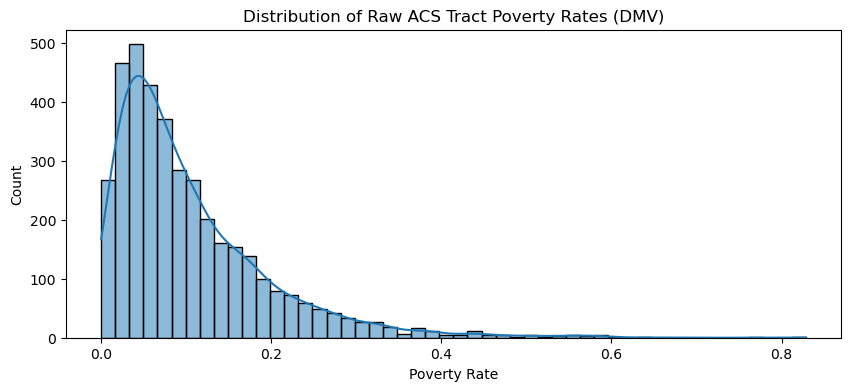

In [39]:
# %% [markdown]
# ## 2. Load & Unify ACS Tract Data
# This is our 'Target' canvas. We need to ensure column names are intuitive.

# %%
tract_path = os.path.join(DATA_DIR, "acs_tract_demographics_2023.csv")
df_tract = pd.read_csv(tract_path)

# Ensure FIPS are strings with leading zeros
df_tract['state'] = df_tract['state'].astype(str).str.zfill(2)
df_tract['county'] = df_tract['county'].astype(str).str.zfill(3)
df_tract['tract'] = df_tract['tract'].astype(str).str.zfill(6)

# Create GEOID keys
df_tract['GEOID_TRACT'] = df_tract['state'] + df_tract['county'] + df_tract['tract']
df_tract['GEOID_COUNTY'] = df_tract['state'] + df_tract['county']

print(f"Loaded {len(df_tract)} Census Tracts.")

# Check for "Impossible" Tracts in Raw Data
# (Where Official Poverty Count < SNAP Household Count from the same source? Wait, SNAP is usually people or households)
# Let's check Poverty Rate distribution
df_tract['raw_poverty_rate'] = df_tract['poverty_count'] / df_tract['total_population']

plt.figure(figsize=(10, 4))
sns.histplot(df_tract['raw_poverty_rate'].dropna(), bins=50, kde=True)
plt.title("Distribution of Raw ACS Tract Poverty Rates (DMV)")
plt.xlabel("Poverty Rate")
plt.show()

Rows with missing Poverty Status: 509 / 5000


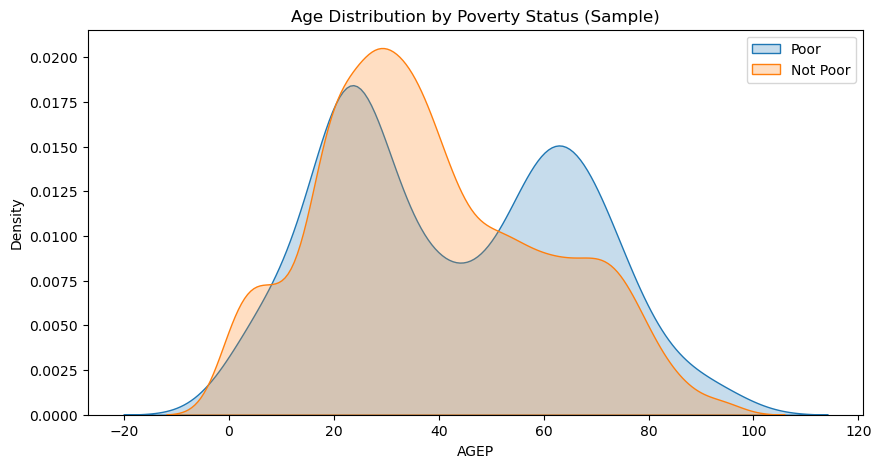

In [40]:
# %% [markdown]
# ## 3. PUMS Data Exploration (The Training Data)
# We need to verify if we have enough 'signal' to learn from.

# %%
# Load a sample of PUMS Person Data
p_files = [f for f in os.listdir(DATA_DIR) if f.startswith('psam_p') and f.endswith('.csv')]
df_pums_sample = pd.read_csv(os.path.join(DATA_DIR, p_files[0]), nrows=5000)

# Unify Column Names (Create a 'Standard' Dictionary)
# We will do the full renaming in the Cleaning Notebook, but let's test the logic here.
pums_rename = {
    'AGEP': 'age',
    'SEX': 'sex',
    'RAC1P': 'race_code',
    'POVPIP': 'poverty_income_ratio', # <100 is poor
    'HINCP': 'household_income', # Note: This is usually on Housing file, but PUMS person often has it? Check.
    # Wait, HINCP is in the Housing file (psam_h), not Person (psam_p) usually, unless merged.
    # The Person file has PINCP (Personal Income).
}

# Check if POVPIP is populated
missing_pov = df_pums_sample['POVPIP'].isna().sum()
print(f"Rows with missing Poverty Status: {missing_pov} / {len(df_pums_sample)}")

# Quick Viz: Poverty by Age
# POVPIP < 100 means 'In Poverty'
df_pums_sample['is_poor'] = df_pums_sample['POVPIP'] < 100

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_pums_sample[df_pums_sample['is_poor']==1], x='AGEP', label='Poor', fill=True)
sns.kdeplot(data=df_pums_sample[df_pums_sample['is_poor']==0], x='AGEP', label='Not Poor', fill=True)
plt.title("Age Distribution by Poverty Status (Sample)")
plt.legend()
plt.show()

In [41]:
# %%
# --- LOAD SNAP DATA ---
# We need to load the clean CSV we just created into memory
snap_path = os.path.join(DATA_DIR, "snap_county_data_clean.csv")

if os.path.exists(snap_path):
    df_snap_dmv = pd.read_csv(snap_path)
    
    # Ensure FIPS is a 5-digit string (e.g. "24031")
    df_snap_dmv['GEOID_COUNTY'] = df_snap_dmv['fips'].astype(str).str.zfill(5)
    
    # Create separate state/county codes if needed for other merges
    df_snap_dmv['state_fips'] = df_snap_dmv['GEOID_COUNTY'].str[:2]
    df_snap_dmv['county_fips'] = df_snap_dmv['GEOID_COUNTY'].str[2:]
    
    print(f"Loaded SNAP Data: {len(df_snap_dmv)} counties.")
    print(df_snap_dmv.head())
else:
    print("❌ SNAP clean file not found. Run the download/process block first.")

Loaded SNAP Data: 149 counties.
                                    fips  county_name  snap_persons_total  \
0           1100161 DC FSP D.C. Treasury        35021             58175.0   
1    2400101 MD FSP ALLEGANY CO SOC SVCS         3565              7637.0   
2  2400301 MD FSP ANNE ARUNDEL CO SOC SV         5878             10044.0   
3   2400501 MD FSP BALTIMORE CO SOC SVCS        10781             15539.0   
4     2400901 MD FSP CALVERT CO SOC SVCS          944              1710.0   

                            GEOID_COUNTY state_fips  \
0           1100161 DC FSP D.C. Treasury         11   
1    2400101 MD FSP ALLEGANY CO SOC SVCS         24   
2  2400301 MD FSP ANNE ARUNDEL CO SOC SV         24   
3   2400501 MD FSP BALTIMORE CO SOC SVCS         24   
4     2400901 MD FSP CALVERT CO SOC SVCS         24   

                           county_fips  
0           00161 DC FSP D.C. Treasury  
1    00101 MD FSP ALLEGANY CO SOC SVCS  
2  00301 MD FSP ANNE ARUNDEL CO SOC SV  
3   00501 

Fixed FIPS codes (Example): 11001
Correlation between Official Poverty Count (SAIPE) and SNAP Recipients:
                     saipe_poverty_count  snap_persons_total
saipe_poverty_count                  NaN                 NaN
snap_persons_total                   NaN                 NaN


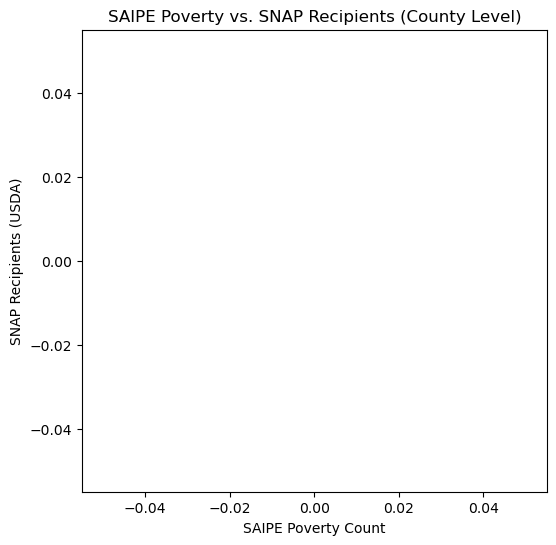

In [42]:
# %% [markdown]
# ## 4. The "Gold Standard" Comparison (SAIPE)
# Let's see what the official county aggregates look like compared to our raw data.

# %%
saipe_path = [f for f in os.listdir(DATA_DIR) if 'saipe' in f and f.endswith('.csv')]
if saipe_path:
    df_saipe = pd.read_csv(os.path.join(DATA_DIR, saipe_path[0]))
    
    # Create GEOID
    df_saipe['state_fips'] = df_saipe['state_fips'].astype(str).str.zfill(2)
    df_saipe['county_fips'] = df_saipe['county_fips'].astype(str).str.zfill(3)
    df_saipe['GEOID_COUNTY'] = df_saipe['state_fips'] + df_saipe['county_fips']
    
    # Merge SAIPE with SNAP
    df_compare = pd.merge(df_saipe, df_snap_dmv, on='GEOID_COUNTY', how='inner')
    # --- FIX: Clean the Identifiers ---
    # The raw 'fips' column contains the full Office ID (e.g. "2400101 MD FSP...").
    # We only want the first 5 digits (State + County FIPS).
    df_snap_dmv['GEOID_COUNTY'] = df_snap_dmv['fips'].astype(str).str[:5]

    # Now we can safely create state/county parts
    df_snap_dmv['state_fips'] = df_snap_dmv['GEOID_COUNTY'].str[:2]
    df_snap_dmv['county_fips'] = df_snap_dmv['GEOID_COUNTY'].str[2:]

    print(f"Fixed FIPS codes (Example): {df_snap_dmv['GEOID_COUNTY'].iloc[0]}")
    # Should print "11001" or "24001"
    
    print("Correlation between Official Poverty Count (SAIPE) and SNAP Recipients:")
    print(df_compare[['saipe_poverty_count', 'snap_persons_total']].corr())
    
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=df_compare, x='saipe_poverty_count', y='snap_persons_total')
    plt.plot([0, df_compare['saipe_poverty_count'].max()], [0, df_compare['saipe_poverty_count'].max()], 'r--')
    plt.title("SAIPE Poverty vs. SNAP Recipients (County Level)")
    plt.xlabel("SAIPE Poverty Count")
    plt.ylabel("SNAP Recipients (USDA)")
    plt.show()
else:
    print("No SAIPE data found.")

/var/folders/0s/d2ycgfq576zdm73qwlf4r6gc0000gn/T/ipykernel_50685/1599286538.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='is_poor', data=df_p_clean, palette='viridis')


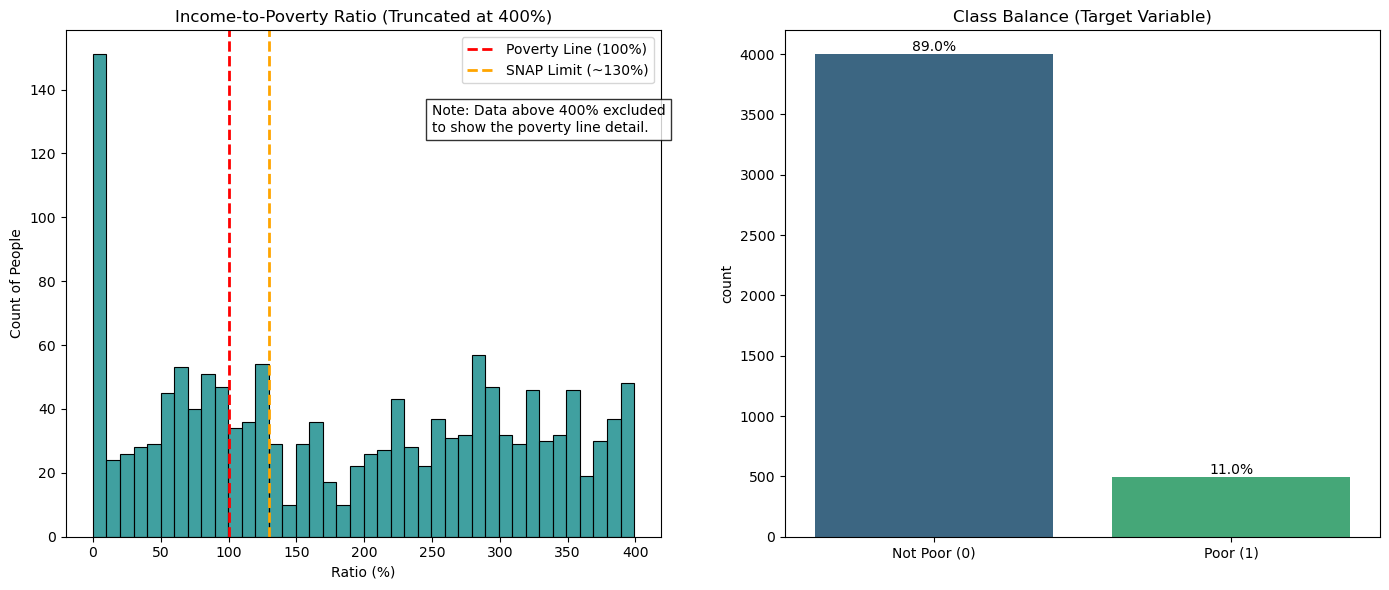

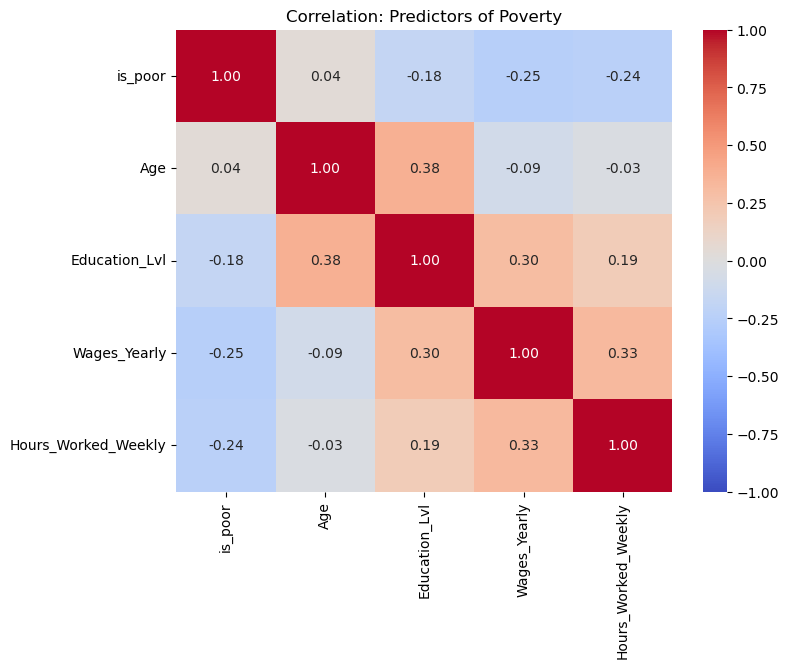

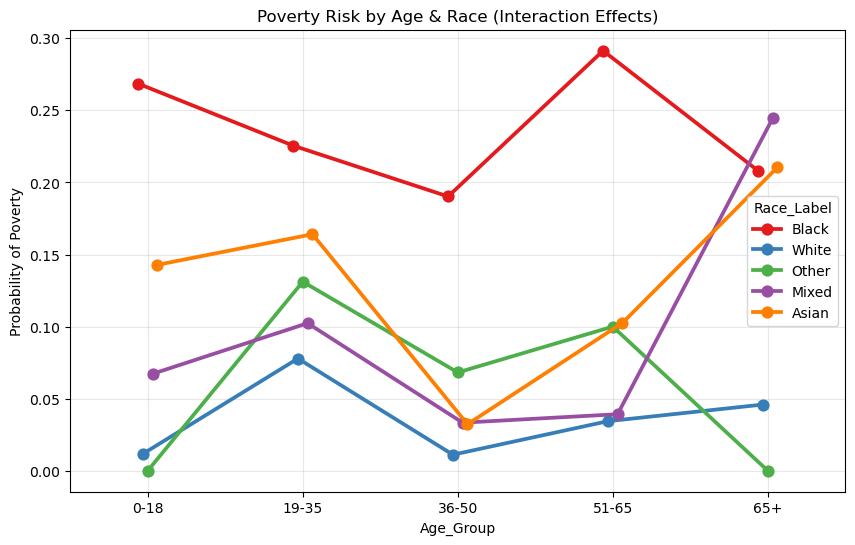

In [43]:
# %%
# --- STEP 4: EXPLORATORY DATA ANALYSIS (EDA) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. PREPARE THE DATA
# We need to create the binary target 'is_poor' and map Race codes.
if 'Poverty_Ratio' in df_p_clean.columns:
    # Create Binary Target (< 100% of Poverty Line)
    df_p_clean['is_poor'] = (df_p_clean['Poverty_Ratio'] < 100).astype(int)
    
    # Map Race Codes (Simplified)
    # 1=White, 2=Black, 6=Asian, 8=Other/Mixed
    race_map = {1: 'White', 2: 'Black', 6: 'Asian', 8: 'Other', 9: 'Mixed'}
    df_p_clean['Race_Label'] = df_p_clean['Race_Code'].map(race_map).fillna('Other')
    
    # Map Education
    df_p_clean['Edu_Label'] = pd.cut(df_p_clean['Education_Lvl'], 
                                     bins=[0, 15, 20, 24], 
                                     labels=['No Degree', 'HS/Some College', 'Bachelor+'])

# -------------------------------------------------------
# PLOT 1: THE "CLIFF" (Truncated at 400% for Visibility)
# -------------------------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# Filter: Drop the wealthy (>400%) to focus on the poverty line
subset = df_p_clean[df_p_clean['Poverty_Ratio'] <= 400]

sns.histplot(subset['Poverty_Ratio'], bins=40, color='teal', kde=False)

# Add Lines
plt.axvline(100, color='red', linestyle='--', linewidth=2, label='Poverty Line (100%)')
plt.axvline(130, color='orange', linestyle='--', linewidth=2, label='SNAP Limit (~130%)')

plt.title("Income-to-Poverty Ratio (Truncated at 400%)")
plt.xlabel("Ratio (%)")
plt.ylabel("Count of People")
plt.legend()
plt.text(250, plt.gca().get_ylim()[1]*0.8, 
         "Note: Data above 400% excluded\nto show the poverty line detail.", 
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.subplot(1, 2, 2)
# Class Balance
ax = sns.countplot(x='is_poor', data=df_p_clean, palette='viridis')
plt.title("Class Balance (Target Variable)")
plt.xticks([0, 1], ['Not Poor (0)', 'Poor (1)'])
plt.xlabel("")
# Add percentages
total = len(df_p_clean)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# PLOT 2: CORRELATION MATRIX (The "Drivers")
# -------------------------------------------------------
cols_to_corr = ['is_poor', 'Age', 'Education_Lvl', 'Wages_Yearly', 'Hours_Worked_Weekly']
corr_mat = df_p_clean[cols_to_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation: Predictors of Poverty")
plt.show()

# -------------------------------------------------------
# PLOT 3: THE "STRUCTURE" (Age x Race Interaction)
# -------------------------------------------------------
# Create Age Buckets
df_p_clean['Age_Group'] = pd.cut(df_p_clean['Age'], bins=[0, 18, 35, 50, 65, 100], 
                                 labels=['0-18', '19-35', '36-50', '51-65', '65+'])

plt.figure(figsize=(10, 6))
sns.pointplot(data=df_p_clean, x='Age_Group', y='is_poor', hue='Race_Label', 
              dodge=True, errorbar=None, palette='Set1')

plt.title("Poverty Risk by Age & Race (Interaction Effects)")
plt.ylabel("Probability of Poverty")
plt.grid(True, alpha=0.3)
plt.show()

Layering GIS Data... (Downloading shapefiles if needed)
DEBUG: Targeting 149 counties.
✅ Shapefile loaded. Mapping 3827 tracts.


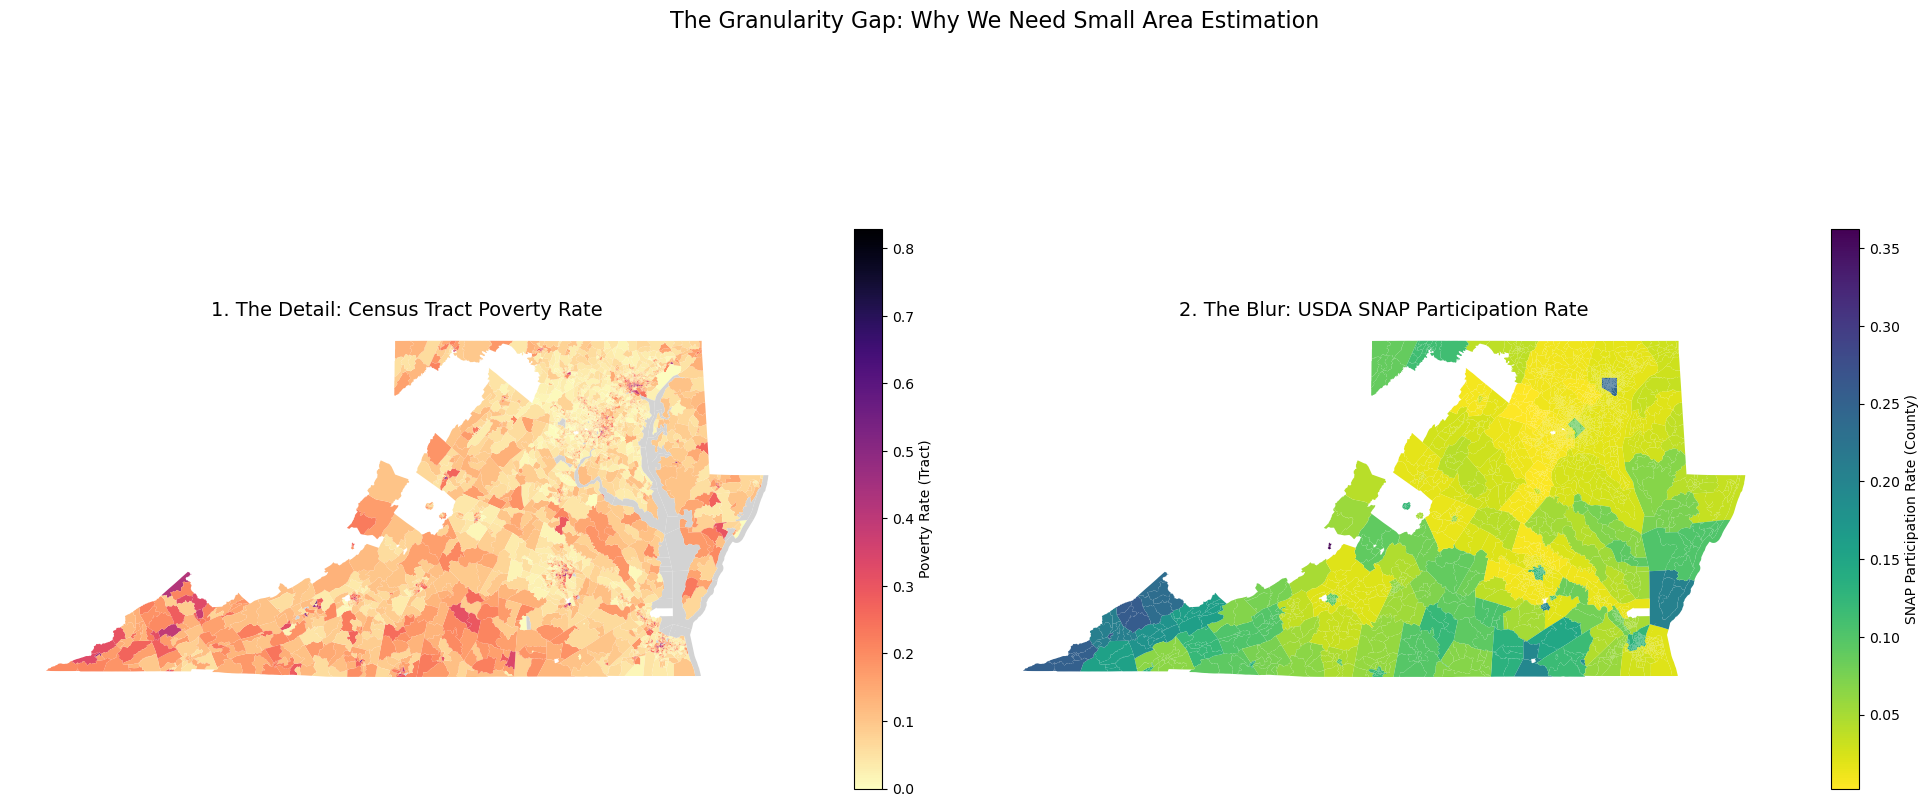

In [44]:
# %%
# --- STEP 5: GIS VISUALIZATION (FIXED MERGE) ---
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

def plot_dmv_heatmaps():
    print("Layering GIS Data... (Downloading shapefiles if needed)")

    # --- 1. SAFEGUARD: Ensure SNAP Data is Clean ---
    if 'fips' in df_snap_dmv.columns:
        clean_snap_geoids = df_snap_dmv['fips'].astype(str).str.zfill(5).str[:5]
    else:
        clean_snap_geoids = df_snap_dmv['GEOID_COUNTY'].astype(str).str.zfill(5).str[:5]
    
    target_counties = clean_snap_geoids.unique().tolist()
    print(f"DEBUG: Targeting {len(target_counties)} counties.")

    # --- 2. LOAD SHAPEFILES ---
    urls = [
        "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_11_tract.zip",
        "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_24_tract.zip",
        "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_51_tract.zip"
    ]
    
    gdf_list = []
    for url in urls:
        try:
            gdf_part = gpd.read_file(url)
            gdf_list.append(gdf_part)
        except Exception as e:
            print(f"⚠️ Failed to download: {url}")
            continue

    if not gdf_list:
        print("❌ All downloads failed.")
        return

    gdf = pd.concat(gdf_list, ignore_index=True)
    
    # --- 3. FILTER SHAPES ---
    gdf['county_geoid'] = gdf['GEOID'].astype(str).str[:5]
    gdf_dmv = gdf[gdf['county_geoid'].isin(target_counties)].copy()
    
    print(f"✅ Shapefile loaded. Mapping {len(gdf_dmv)} tracts.")

    # --- 4. THE CONNECTOR (CRITICAL FIX) ---
    # We must ensure both Dataframes use 11-digit STRING IDs for the merge.
    
    # A. Fix Shapefile ID
    gdf_dmv['GEOID'] = gdf_dmv['GEOID'].astype(str).str.strip()
    
    # B. Fix Tract Data ID
    # If GEOID is int, it might lose leading zeros. We pad it to 11 chars.
    df_tract['GEOID_MATCH'] = df_tract['GEOID'].astype(str).str.zfill(11)
    
    # C. Calculate Poverty Rate (if needed)
    df_tract['poverty_rate'] = df_tract['poverty_count'] / df_tract['total_population']
    
    # D. Merge using the CLEAN keys
    # Note: We merge on 'GEOID' from map and 'GEOID_MATCH' from data
    gdf_dmv = gdf_dmv.merge(df_tract[['GEOID_MATCH', 'poverty_rate', 'total_population']], 
                            left_on='GEOID', right_on='GEOID_MATCH', how='left')

    # --- 5. PREPARE SNAP DATA (County Level) ---
    df_tract['GEOID_COUNTY'] = df_tract['GEOID_MATCH'].str[:5]
    county_pop = df_tract.groupby('GEOID_COUNTY')['total_population'].sum().reset_index()
    
    df_snap_dmv['clean_geoid'] = clean_snap_geoids
    df_snap_map = df_snap_dmv.merge(county_pop, left_on='clean_geoid', right_on='GEOID_COUNTY', how='inner')
    df_snap_map['snap_rate'] = df_snap_map['snap_persons_total'] / df_snap_map['total_population']
    
    # Merge SNAP Rate -> Shapefile
    gdf_dmv = gdf_dmv.merge(df_snap_map[['clean_geoid', 'snap_rate']], 
                            left_on='county_geoid', right_on='clean_geoid', how='left')

    # --- 6. PLOT ---
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    # Map 1: Census Poverty
    gdf_dmv.plot(column='poverty_rate', cmap='magma_r', linewidth=0,
                 legend=True, legend_kwds={'label': "Poverty Rate (Tract)", 'shrink': 0.6},
                 missing_kwds={'color': 'lightgrey'}, ax=ax[0])
    ax[0].set_title("1. The Detail: Census Tract Poverty Rate", fontsize=14)
    ax[0].set_axis_off()
    
    # Map 2: USDA SNAP
    gdf_dmv.plot(column='snap_rate', cmap='viridis_r', linewidth=0,
                 legend=True, legend_kwds={'label': "SNAP Participation Rate (County)", 'shrink': 0.6},
                 missing_kwds={'color': 'lightgrey'}, ax=ax[1])
    ax[1].set_title("2. The Blur: USDA SNAP Participation Rate", fontsize=14)
    ax[1].set_axis_off()
    
    plt.suptitle("The Granularity Gap: Why We Need Small Area Estimation", fontsize=16)
    plt.tight_layout()
    plt.show()

try:
    plot_dmv_heatmaps()
except Exception as e:
    print(f"❌ Error plotting: {e}")
    